# PyTorch Device

In [31]:
import torch

In [32]:
# Choose torch device

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print("Using device:", device)

Using device: mps


# Dataset Utils

In [33]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import scipy as sp
import matplotlib.pyplot as plt

In [34]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        super(CustomDataset, self).__init__()
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [35]:
def loadSyntheticData(file, dtype=torch.float32):
    """
    Load synthetic dataset used by Tishby et al. (2017). Store in torch tensor.

    Args:
        file: str, path for the dataset.
        dtype: torch.dtype, data type for the tensors.

    Returns:
        data: torch.tensor, input data (number of samples, number of features)
        targets: torch.tensor, targets for the input data (number of samples)
    """

    synthetic = sp.io.loadmat(file)

    data = torch.tensor(synthetic['F'], dtype=dtype)
    targets = torch.tensor(synthetic['y'].ravel())

    return data, targets

In [36]:
def loadMNISTData(root):
    """
    Load MNIST dataset from torchvision.datasets.MNIST.

    Args:
        root: str, root directory for storing the dataset.

    Returns:
        data: torch.tensor, input data (number of samples, number of features)
        targets: torch.tensor, targets for the input data (number of samples)
    """

    mnist_train = torchvision.datasets.MNIST(root=root, train=True, download=True)
    mnist_test = torchvision.datasets.MNIST(root=root, train=False, download=True)

    data = torch.vstack( [mnist_train.data, mnist_test.data] ).reshape(-1, 28*28).to(torch.float32) / 255.0
    targets = torch.hstack( [mnist_train.targets, mnist_test.targets] )

    return data, targets

In [37]:
def buildDatasets(data, targets, ratio=0.8, seed=0, name=None):
    """
    Build training and test datasets from the given data and targets.

    Args:
        data: torch.tensor, input data.
        targets: torch.tensor, targets for the input data.
        ratio: float, ratio of the training set to the test set.
        seed: int, random seed for the data shuffling.
    
    Returns:
        dataset: dict, dictionary containing training and test datasets, as well as the full dataset and the number of features.
    """
    torch.manual_seed(seed)

    n = len( data )
    n_train = int( n * ratio )
    idx = torch.randperm( n )

    dataset = dict()
    dataset["train"] = CustomDataset( data[ idx[:n_train] ], targets[ idx[:n_train] ] )
    dataset["test"] = CustomDataset( data[ idx[n_train:] ], targets[ idx[n_train:] ] )
    dataset["full"] = CustomDataset( data, targets )
    dataset["n_features"] = data.shape[1]
    dataset["name"] = name

    return dataset

In [38]:
def buildDataLoader(dataset, batch_size=64):
    """
    Build data loaders for the given dataset.

    Args:
        dataset: dict, dictionary containing training and test datasets, as well as the full dataset and the number of features.
        batch_size: int, size of the mini-batches.
    
    Returns:
        loader: dict, dictionary containing training and test data loaders, as well as the dataset dictionary.
    """
    
    if batch_size is None: # full batch instead of mini-batch
        batch_size_train  = len( dataset["train"] )
        batch_size_test = len( dataset["test"] )
    else:
        batch_size_train = batch_size
        batch_size_test = batch_size

    loader = dict()
    loader["train"] = DataLoader( dataset["train"], batch_size=batch_size_train, shuffle=True )
    loader["test"] = DataLoader( dataset["test"], batch_size=batch_size_test, shuffle=True )
    loader["dataset"] = dataset

    return loader

In [39]:
def plotimg(arr, width=28, height=28):
        """
        Plot gray scale image given as array.

        Example usage in subplots:
            plt.figure()
            plt.subplot(2,2,1)
            data.plot(0)
            plt.subplot(2,2,2)
            data.plot(1)
            plt.show()
        """
        plt.imshow(arr.reshape(width, height), cmap='gray')

# MI Utils

In [40]:
import numpy as np

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [42]:
def get_distribution(x): # compute array's row distribution

    """
    unique, unique_invese, unique_counts = np.unique(x, axis=0, return_index=False, return_inverse=True, return_counts=True)
    unique : sorted unique values
    unique_inverse : indices to reconstruct original array from unique array
    unique_counts : number of times each unique value appears in the original array

    obs: the unique_inverse indices will be used instead of the unique values since what matters is the distribution, not the values themselves
    """
    _, unique_inverse, unique_counts = np.unique(x, axis=0, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def get_distribution_optimized(x): # compute array's row distribution

    """
    unique, unique_invese, unique_counts = np.unique(x, axis=0, return_index=False, return_inverse=True, return_counts=True)
    unique : sorted unique values
    unique_inverse : indices to reconstruct original array from unique array
    unique_counts : number of times each unique value appears in the original array

    obs: the unique_inverse indices will be used instead of the unique values since what matters is the distribution, not the values themselves
    """
    _, unique_inverse, unique_counts = np.unique(x, axis=0, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

In [43]:
def mi_xt(x, t, n_bins=30):
    """
    Compute mutual information (MI) between neural network inputs and layer activations.

    Args:
        x : inputs
        t : tanh activations
        n_bins : number of bins used to discretize activations
    """

    p_x, unique_inverse_x = get_distribution( x )   # input distribution
    
    # bin tanh activations into n_bins intervals
    bins = np.linspace(-1, 1, n_bins, dtype='float32')  # determine bin boundaries
    t_binned = bins[ np.digitize(t, bins) - 1 ]         # determine to which bin each activation value belongs to and substitute for binned value

    p_t, unique_inverse_t = get_distribution( t_binned )    # binned activation's distribution
    
    h_layer = -np.sum(p_t * np.log(p_t)) # H(T): entropy of activation's distribution

    # H(T|X): entropy of the activations given the inputs
    h_layer_given_input = 0.
    for x_val in range( len(p_x) ):
        p_t_given_x, _ = get_distribution( t_binned[unique_inverse_x == x_val] )            # # binned activation's distribution conditionned on the inputs
        h_layer_given_input += - p_x[x_val] * np.sum(p_t_given_x * np.log(p_t_given_x))

    return h_layer - h_layer_given_input

def mi_xt_optimized(x, t, n_bins=30):
    """
    Compute mutual information (MI) between neural network inputs and layer activations.

    Args:
        x : inputs
        t : tanh activations
        n_bins : number of bins used to discretize activations
    """

    p_x, unique_inverse_x = get_distribution_optimized( x )   # input distribution
    
    # bin tanh activations into n_bins intervals
    bins = np.linspace(-1, 1, n_bins, dtype='float32')  # determine bin boundaries
    t_binned = bins[ np.digitize(t, bins) - 1 ]         # determine to which bin each activation value belongs to and substitute for binned value

    p_t, unique_inverse_t = get_distribution_optimized( t_binned )    # binned activation's distribution
    
    h_layer = -np.sum(p_t * np.log(p_t)) # H(T): entropy of activation's distribution

    # H(T|X): entropy of the activations given the inputs (equals to zero since the network is deterministic, i.e., the activations are fully determined by the inputs)
    h_layer_given_input = 0.
    # for x_val in range( len(p_x) ):
    #     p_t_given_x, _ = get_distribution( t_binned[unique_inverse_x == x_val] )            # binned activation's distribution conditionned on the inputs
    #     h_layer_given_input += - p_x[x_val] * np.sum(p_t_given_x * np.log(p_t_given_x))

    return h_layer - h_layer_given_input

In [44]:
def mi_ty(y, t, n_bins=30):
    """
    Compute mutual information (MI) between layer activations and neural network outputs

    Args:
        y : labels
        t : tanh activations
        n_bins : number of bins used to discretize activations
    """

    p_y, unique_inverse_y = get_distribution( y )   # output distribution

    # bin tanh activations into n_bins intervals
    bins = np.linspace(-1, 1, n_bins, dtype='float32')  # determine bin boundaries
    t_binned = bins[ np.digitize(t, bins) - 1 ]         # determine to which bin each activation value belongs to and substitute for binned value

    p_t, unique_inverse_t = get_distribution( t_binned )    # binned activation's distribution

    h_layer = -np.sum(p_t * np.log(p_t)) # H(T): entropy of activation's distribution

    # H(T|Y): entropy of the activations given the outputs
    h_layer_given_output = 0.
    for y_val in range( len(p_y) ):
        p_t_given_y, _ = get_distribution( t_binned[unique_inverse_y == y_val] )            # # binned activation's distribution conditionned on the outputs
        h_layer_given_output += - p_y[y_val] * np.sum(p_t_given_y * np.log(p_t_given_y))

    return h_layer - h_layer_given_output

def mi_ty_optimized(y, t, n_bins=30):
    """
    Compute mutual information (MI) between layer activations and neural network outputs

    Args:
        y : labels
        t : tanh activations
        n_bins : number of bins used to discretize activations
    """

    p_y, unique_inverse_y = get_distribution_optimized( y )   # output distribution

    # bin tanh activations into n_bins intervals
    bins = np.linspace(-1, 1, n_bins, dtype='float32')  # determine bin boundaries
    t_binned = bins[ np.digitize(t, bins) - 1 ]         # determine to which bin each activation value belongs to and substitute for binned value

    p_t, unique_inverse_t = get_distribution_optimized( t_binned )    # binned activation's distribution

    h_layer = -np.sum(p_t * np.log(p_t)) # H(T): entropy of activation's distribution

    # H(T|Y): entropy of the activations given the outputs
    h_layer_given_output = 0.
    for y_val in range( len(p_y) ):
        p_t_given_y, _ = get_distribution_optimized( t_binned[unique_inverse_y == y_val] )            # # binned activation's distribution conditionned on the outputs
        h_layer_given_output += - p_y[y_val] * np.sum(p_t_given_y * np.log(p_t_given_y))

    return h_layer - h_layer_given_output

In [45]:
def plot_info_plan(mi_xt, mi_yt):

    mi_xt = np.array( mi_xt )
    mi_yt = np.array( mi_yt )

    n_saved_epochs = mi_xt.shape[0]
    n_layers = mi_xt.shape[1]
    c = np.arange(n_saved_epochs)+1 # color according to epochs

    plt.figure()
    for e in range(n_saved_epochs):
        plt.plot(mi_xt[e, :], mi_yt[e, :], c='k', linewidth=0.5, alpha=0.5)
    for l in range(n_layers):
        plt.scatter(mi_xt[:, l], mi_yt[:, l], c=c, cmap='gnuplot', s=20, zorder=3)
    plt.show()

In [46]:
def plot_info_plan2(mi_xt, mi_yt):

    mi_xt = np.array( mi_xt )
    mi_yt = np.array( mi_yt )

    n_saved_epochs = mi_xt.shape[0]
    n_layers = mi_xt.shape[1]
    c = np.arange(n_saved_epochs)+1 # color according to epochs

    plt.figure()
    for l in range(n_layers):
        plt.plot(mi_xt[:, l], mi_yt[:, l], c='k', linewidth=0.5, alpha=0.5)
        plt.scatter(mi_xt[:, l], mi_yt[:, l], c=c, cmap='gnuplot', s=20, zorder=3)
    plt.show()

# Neural Network Utils

In order to have more generic code, the network and training parameters should be specified through the setup dictionary. The required keys are:
- **hidden_dims**: list of hidden layers sizes
- **output_dim**: output layer size
- **hidden_activation_f**: activation function for the hidden layers
- **output_activation_f**: activation function for the output layer
- **n_epochs**: number of epochs
- **batch_size**: batch size, if None, do batch training (use the total training data for each update) instead of mini-batch
- **optimizer**: optimizer from ```torch.optim``` encapsulated on a lambda function that receives as argument only the parameters to optimize 
- **loss_function**: loss function with the signature ```loss_function(output, target, reduction='mean')```
where output and target are the network output and the target values, respectively, 
the reduction parameter is necessary due to train and test time differences, the default value must be 'mean'
- **evaluate_correct**: function to evaluate the number of correct predictions, with the signature ```evaluate_correct(output, target)```
where output and target are the network output and the target values, respectively

**WARNING:** When specifying functions, encapsulate them in **lambda expressions** so that the setup can be saved to and loaded from json files!

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [48]:
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, hidden_activation_f=F.tanh, output_activation_f=F.sigmoid):
        """
        Args:
            input_dim: int, size of the input layer.
            hidden_dims: list of int, sizes of the hidden layers.
            output_dim: int, size of the output layer.
            hidden_activation_function: torch.nn.functional or torch.nn activation function, activation function for the hidden layers.
            output_activation_function: torch.nn.functional or torch.nn activation function, activation function for the output layer.
        """
        super(Network, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_hidden_layers = len(hidden_dims)
        
        self.hidden_activation_f = hidden_activation_f
        self.output_activation_f = output_activation_f

        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for dim in hidden_dims + [output_dim]:
            self.layers.append( nn.Linear(prev_dim, dim) )
            prev_dim = dim
        
    
    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = self.hidden_activation_f( layer(x) )
            activations.append( x )
            
        x = self.output_activation_f( self.layers[-1](x) )
        activations.append( x )
        return x, activations

In [49]:
def train(model, setup, train_loader, optimizer, device, epoch, verbose=1):
    """
    Train the model for one epoch.

    Args:
        model: torch.nn.Module, model to train.
        setup: dict, dictionary containing the loss function
        train_loader: torch.utils.data.DataLoader, data loader for the training set.
        optimizer: torch.optim, optimization algorithm.
        device: torch.device, device to use for the computation.
        epoch: int, current epoch number.
        verbose: int, level of verbosity, 0 for no output, 1 for output at the end of the epoch, 2 for output at each batch.
    """

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # move data to device
        data, target = data.to(device), target.to(device)

        # forward pass
        output, _ = model(data)
        loss = setup["loss_function"](output, target)

        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose==2:
            print('\rEpoch {}: Batch {}/{}: train loss {:.4f} '.format(epoch, batch_idx+1, len(train_loader), loss.item()), end='')
    
    if verbose==1:
        print('Epoch {}: train loss {:.4f} '.format(epoch, loss.item()), end='')

In [50]:
def test(model, setup, test_loader, device):
    """
    Evalate the model on test set.

    Args:
        model: torch.nn.Module, model to evaluate.
        setup: dict, dictionary containing the loss function and the evaluation function.
        test_loader: torch.utils.data.DataLoader, data loader for the test set.
        device: torch.device, device to use for the computation.
    """

    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # move data to device
            data, target = data.to(device), target.to(device)
            output, _ = model(data)

            test_loss += setup["loss_function"](output, target, reduction='sum')
            correct += setup["evaluate_correct"](output, target)

    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    print( '-- test loss: {:.4f} -- test acc: {:.4f}\n'.format(test_loss, correct) )

In [51]:
def get_MI(model, dataset, device):

    model.eval()

    with torch.no_grad():
        mi_xt_layers = []
        mi_ty_layers = []

        data, target = dataset.data.to(device), dataset.targets.to(device)
        _, layer_activations = model(data)

        data, target = data.detach().cpu().numpy(), target.detach().cpu().numpy()

        for activation in layer_activations:
            activation = activation.detach().cpu().numpy()
            mi_xt_layers.append( mi_xt_optimized(data, activation) )
            mi_ty_layers.append( mi_ty_optimized(target, activation) )

    return mi_xt_layers, mi_ty_layers

# Experiments

In [20]:
# dataset = buildDatasets( *loadMNISTData(root="data"), ratio=6/7, name="mnist" )
dataset = buildDatasets( *loadSyntheticData(file="data/synthetic/var_u.mat"), name="synthetic" )

In [21]:
print( "Number of samples in the training set:", len(dataset["train"]) )
print( "Number of samples in the test set:", len(dataset["test"]) )

Number of samples in the training set: 3276
Number of samples in the test set: 820


In [22]:
# SETTING 1
# - Synthetic dataset
# - Test accuracy: 0.9426

setup = dict()
# network parameters
setup["hidden_dims"] = [10, 7, 5, 4, 3]                         
setup["output_dim"] = 1                                         
setup["hidden_activation_f"] = lambda input: F.tanh(input)      
setup["output_activation_f"] = lambda input: F.sigmoid(input)   

# optimizer
setup["lr"] = 0.01                             
setup["momentum"] = 0.9
setup["optimizer"] = lambda parameters: torch.optim.SGD( parameters, lr=setup["lr"], momentum=setup["momentum"] )

# training configuration
setup["n_epochs"] = 10000
setup["batch_size"] = None
setup["loss_function"] = lambda output, target, reduction='mean': F.binary_cross_entropy(output.reshape(-1), target.float(), reduction=reduction)
setup["evaluate_correct"] = lambda output, target: torch.sum( torch.round(output.reshape(-1)) == target, dtype=torch.float32 )


In [ ]:
# SETTING 2
# - MNIST
# - Test accuracy: 0.9074

setup = dict()
# network parameters
setup["hidden_dims"] = [256, 256, 128]                                          # hidden layers sizes
setup["output_dim"] = 10                                                        # output layer size
setup["hidden_activation_f"] = lambda input: F.relu(input)                      # activation function for the hidden layers
setup["output_activation_f"] = lambda input: F.log_softmax( input, dim=1 )      # activation function for the output layer

# optimizer
setup["lr"] = 0.01  
setup["optimizer"] = lambda parameters: torch.optim.Adam( parameters, lr=setup["lr"] )       

# training configuration
setup["n_epochs"] = 20
setup["batch_size"] = None
setup["loss_function"] = lambda output, target, reduction='mean': F.nll_loss(output, target, reduction=reduction)
setup["evaluate_correct"] = lambda output, target: torch.sum( output.argmax(dim=1) == target, dtype=torch.float32 )

In [23]:
loader = buildDataLoader(dataset, batch_size=setup["batch_size"])
# batch = next( iter( loader["train"] ) )

In [25]:
saveMI = True
saveMI_interval = 100

model = Network(
            input_dim=dataset["n_features"], 
            hidden_dims=setup["hidden_dims"],
            output_dim=setup["output_dim"],
            hidden_activation_f=setup["hidden_activation_f"],
            output_activation_f=setup["output_activation_f"]
        ).to(device)

optimizer = setup["optimizer"]( model.parameters() )

mi_xt_epochs = []
mi_ty_epochs = []
for epoch in range(1, setup["n_epochs"] + 1):
        train(model, setup, loader["train"], optimizer, device, epoch, verbose=2)
        test(model, setup, loader["test"], device)
        if saveMI and epoch%saveMI_interval == 0:
                mi_xt_layers, mi_ty_layers = get_MI(model, dataset["full"], device)
                mi_xt_epochs.append( mi_xt_layers )
                mi_ty_epochs.append( mi_ty_layers )

Epoch 1: Batch 1/1: train loss 0.7135 -- test loss: 0.7113 -- test acc: 0.4878

Epoch 2: Batch 1/1: train loss 0.7134 -- test loss: 0.7110 -- test acc: 0.4878

Epoch 3: Batch 1/1: train loss 0.7131 -- test loss: 0.7106 -- test acc: 0.4878

Epoch 4: Batch 1/1: train loss 0.7126 -- test loss: 0.7101 -- test acc: 0.4878

Epoch 5: Batch 1/1: train loss 0.7121 -- test loss: 0.7095 -- test acc: 0.4878

Epoch 6: Batch 1/1: train loss 0.7115 -- test loss: 0.7089 -- test acc: 0.4878

Epoch 7: Batch 1/1: train loss 0.7108 -- test loss: 0.7082 -- test acc: 0.4878

Epoch 8: Batch 1/1: train loss 0.7101 -- test loss: 0.7074 -- test acc: 0.4878

Epoch 9: Batch 1/1: train loss 0.7093 -- test loss: 0.7067 -- test acc: 0.4878

Epoch 10: Batch 1/1: train loss 0.7084 -- test loss: 0.7059 -- test acc: 0.4878

Epoch 11: Batch 1/1: train loss 0.7076 -- test loss: 0.7051 -- test acc: 0.4878

Epoch 12: Batch 1/1: train loss 0.7067 -- test loss: 0.7043 -- test acc: 0.4878

Epoch 13: Batch 1/1: train loss 0.705

In [26]:
# Save experiment setup and results

import json
import inspect
import datetime

# File naming convention: dataset name and timestamp (to avoid overwritting previous results)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
fpath="./save/"
fname = "{}-{}".format(dataset["name"], timestamp)

# Save setup to json
def default( o ):
    """
    Default function for json.dump to handle non-serializable objects. 
    Specifically we wish to handle entries that are lambda functions. We will save the source code of the function instead.
    """
    # inspect.getsource( value )
    f_str = '='.join( inspect.getsource( o ).split('=')[1:] )[1:]
    return f_str

with open( fpath+fname+".json", "w" ) as outfile: 
    json.dump(setup, outfile, default=default, indent=0)

# Save MI results as compressed numpy file
np.savez_compressed( fpath+fname, mi_xt_epochs=mi_xt_epochs, mi_ty_epochs=mi_ty_epochs )

In [52]:
load_fpath = "./save/"
load_fname = "{}-{}".format(dataset["name"], timestamp)

# Load setup and convert lambda source code to lambda function
with open( load_fpath+load_fname+".json", "r" ) as infile: 
    loaded_results = json.load(infile)
for key in ["hidden_activation_f", "output_activation_f", "optimizer", "loss_function", "evaluate_correct"]:
    loaded_results[key] = eval( loaded_results[key] )

# Load results
loaded_results = np.load( load_fpath+load_fname+".npz" )
loaded_mi_xt_epochs = loaded_results["mi_xt_epochs"]
loaded_mi_ty_epochs = loaded_results["mi_ty_epochs"]

In [ ]:
plot_info_plan(mi_xt_epochs, mi_ty_epochs)

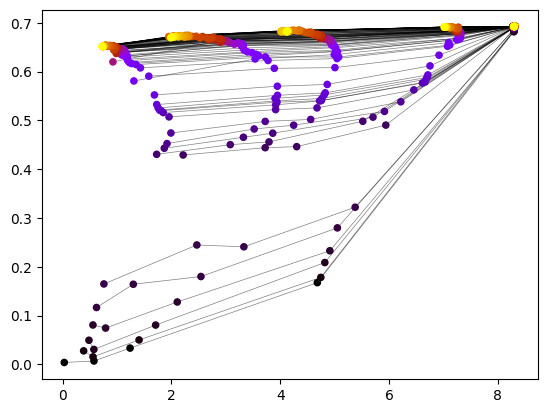

In [53]:
plot_info_plan(loaded_mi_xt_epochs, loaded_mi_ty_epochs)